# Stereographic Projections

### Imports, Functions, and Basic Data

In [2]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
import matplotlib.pyplot as plt
import math

import star_chart_spherical_projection as scsp
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun, Angle, Longitude
from sunpy.coordinates import frames, sun

In [3]:

def SunRiseSet(jd, SunAlt, deg):
    
    '''
    A function to create a list of indices where the Sun rises and sets in a given year. 
    This is useful for making sure we're tracking nightly, visible motion of the decans.
    Inputs: 
        jd = Julian date
        SunAlt = the altitude of the Sun
    Outputs:
        sunriseset = indices of sunrize and sunset in the jd & date columns
    '''
    
    sunriseset = []
    for i in range(360, len(jd), 360):
        temp = []
        for j in range(i - 360, i):
            if SunAlt[j] <= deg + 0.4 and SunAlt[j] >= deg - 0.4:
                if len(temp) == 0: 
                    temp.append(j)
                elif temp[-1] != j - 1:
                    temp.append(j)
        sunriseset.append(temp)
    return sunriseset




# def nightHourLength(jd, sunriseset):
#     hrlen = [];
#     dhour = 0.04166666674427688

#     for i in sunriseset:
#         night = jd[i[1]] - jd[i[0]]
#         hrlen.append((night/dhour) * (60/12))
#     return(hrlen)


def nightHourLength(jd, sunrise, sunset):
    hrlen = [];
    dhour = 0.04166666674427688

    for i in range(0,len(sunrise)-1):
        night = jd[sunrise[i + 1][0]] - jd[sunset[i][1]]
        hrlen.append((night/dhour) * (60/12))
    return(hrlen)
# Import Decan Data

def ImportDecanData(direct, filename):
    
    '''
    A function to import data from a decanOpy-generated .txt file. 
    Inputs: 
        direct = string with the directory where the .txt file is located
        filename = string with name of file (name + month + year)
    Outputs:
        jd = Julian date
        date = human readable date
        DecAz = the azimuth of the decan
        DecAlt = the altitude of the decan
        SunAz = the azimuth of the Sun
        SunAlt = the altitude of the Sun
    '''
    
    jd = []
    date = []
    DecAz = []
    DecAlt = []
    SunAz = []
    SunAlt = []
    # Import Single Object
    with open(direct + filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter='|')
        decan = next(csv_reader)[0]
        location = next(csv_reader)[0]
        trash = next(csv_reader)
        headers = next(csv_reader)
        for row in csv_reader:
            # time info
            jd.append(float(row[0]))
            date.append(row[1])
            # decan info
            DecAz.append(float(row[2][0:-4]))
            DecAlt.append(float(row[3][0:-4]))
            # solar info
            SunAz.append(float(row[4][0:-4]))
            SunAlt.append(float(row[5][0:-4]))
    return(jd, date, DecAz, DecAlt, SunAz, SunAlt)

In [4]:
### Set the directory
direct = os.getcwd() # current working directory
direct = direct + '/DecanLists' # directory where the .txt files go

### Determine the filenames

Sirius_filename = ['/Sirius011300BC.txt']
Orion_filename = ['/Rigel011300BC.txt', '/Betelgeuse011300BC.txt']
Dipper_filename = ['/Alkaid011300BC.txt', '/Alioth011300BC.txt', '/Merak011300BC.txt']

# Sirius
(jd, date, SiriusAz, SiriusAlt, SunAz, SunAlt) = ImportDecanData(direct, Sirius_filename[0])

# use Nautical twilight definition (fits data best)
binrange = range(20, 70, 4)

sunriseset12 = SunRiseSet(jd, SunAlt, -12)
hrlen12 = nightHourLength(jd, sunriseset12, sunriseset12) 

### What I'm trying to reproduce


Northern Range of Declination: -30 to 90


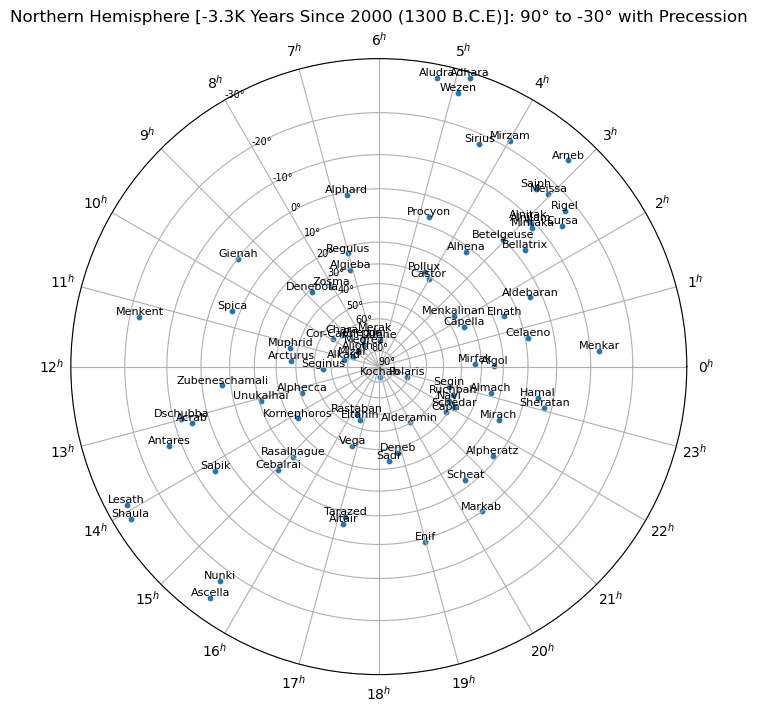

In [35]:
star_final_pos_dict = scsp.finalPositionOfStars(yearSince2000=-3300)
scsp.plotStereographicProjection(northOrSouth="North", yearSince2000=-3300, figsize_n=8)

### Rolling up sleeves...

In [13]:
def getStarList(selectStars=[]):
	# generate a star object
	# selectStars only returns a subset of all the stars saved, empty will return all in the star_data.csv file
	# stars: ["name", "RA: HH.MM.SS", Declination DD.SS, Proper Motion Speed (mas/yr), Proper Motion Angle (DD.SS), Magnitude (V, Visual)]
	star_data_list = []
	star_csv_file = 'star_data.csv'  # get file's directory, up one level, /data/star_data.csv
	star_dataframe = pd.read_csv(star_csv_file)
	for index, row in star_dataframe.iterrows():
		if len(selectStars) > 0: # get only a subset of all stars
			if row["Star Name"] in selectStars:
				star_data_list.append(row.tolist())
		else:
			star_data_list.append(row.tolist())
	return star_data_list

In [22]:
total_ruler_len = 1
radius_of_circle_at_min_dec = (total_ruler_len/2) / math.tan(np.deg2rad(45 - declination_min/2))

In [23]:
radius_of_circle_at_min_dec

0.288675134594813

In [29]:
def generateStereographicProjection(starList=None, 
									northOrSouth=None, 
									yearSince2000=None,
									isPrecessionIncluded=None,
									maxMagnitudeFilter=None,
									declination_min=None,
									declination_max=None):
	# Generate sterographic projections and return declination and right ascension

	# Convert Star chart from RA hours to Radians to chart
	list_of_stars = getStarList(starList)
	list_of_stars = scsp.generate_star_chart.convertRAhrtoRadians(list_of_stars)

	finalPositionOfStarsDict = {} # {'Star Name': {"Declination" : Declination (int), "RA": RA (str)}
	x_star_labels = []
	x_ra_values = []
	y_dec_values = []
	for star in list_of_stars:
		if maxMagnitudeFilter is None or star[5] < maxMagnitudeFilter: # Optional: Filter out stars with a magnitude greater than maxMagnitudeFilter

			#radius_of_circle = star_chart_spherical_projection.calculateRadiusOfCircle(declination_min, northOrSouth)
			total_ruler_len = 1
			radius_of_circle = (total_ruler_len/2) / math.tan(np.deg2rad(45 - declination_min/2))	

			# Calculate position of star due to PROPER MOTION (changes RA and Declination over time)
			star_ra, star_declination = calculateRAandDeclinationViaProperMotion(yearSince2000, 
																				star[1], 
																				star[2], 
																				star[3], 
																				star[4])

			# Optional: Calculate new position of star due to PRECESSION (change RA and Declination over time)
			# Vondrak accurate up  +/- 200K years around 2000
			star_declination, star_ra = precessionVondrak(star[0], star_ra, star_declination, yearSince2000)
			# convert degree to position on radius
			dec_ruler_position = star_chart_spherical_projection.calculateLength(star_declination, radius_of_circle, northOrSouth) 

			in_range_value = False # Determine if within range of South/North Hemisphere
			if star_declination > declination_min and star_declination < declination_max: # only display stars within range of declination values
				in_range_value = True # North
	
			if in_range_value:
				finalPositionOfStarsDict[star[0]] = {"Declination" : star_declination, "RA": convertRadianstoRAhr(star_ra)} # {'Star Name': {"Declination" : Declination (int), "RA": RA (str)}
				x_star_labels.append(star[0])
				x_ra_values.append(star_ra)
				y_dec_values.append(dec_ruler_position)

	return x_star_labels, x_ra_values, y_dec_values, finalPositionOfStarsDict

In [ ]:
total_ruler_len = 1
radius_of_circle = (total_ruler_len/2) / math.tan(np.deg2rad(45 - declination_min/2))	
angle_in_radians = np.deg2rad(45 - angle_of_inclination/2) # + angle for northern projection
dec_ruler_position = equation_of_length = radius_of_circle * math.tan(angle_in_radians) # calculated

			in_range_value = False # Determine if within range of South/North Hemisphere
			if star_declination > declination_min and star_declination < declination_max: # only display stars within range of declination values
				in_range_value = True # North
	
			if in_range_value:
				finalPositionOfStarsDict[star[0]] = {"Declination" : star_declination, "RA": convertRadianstoRAhr(star_ra)} # {'Star Name': {"Declination" : Declination (int), "RA": RA (str)}
				x_star_labels.append(star[0])
				x_ra_values.append(star_ra)
				y_dec_values.append(dec_ruler_position)

In [37]:
### some attributes for plot

fig_plot_title=None
fig_plot_color="C0"
figsize_n=6
figsize_dpi=100
incrementBy = 30
maxMagnitudeFilter = None
northOrSouth = "North"

# Set Declination (astronomical 'latitude') as Y (radius of polar plot)
displayDeclinationNumbers = True

# Set declination based on hemisphere selected
declination_min = -30
declination_max = 90

# Split up chart into North/South hemisphere
declination_values = np.arange(declination_min, declination_max+1, incrementBy) # +1 to show max value in range

# Store the ruler positions based on degrees and the ratio of the ruler
ruler_position_dict = scsp.calculateRuler(declination_min, declination_max, incrementBy, northOrSouth)

In [38]:
ruler_position_dict = scsp.calculateRuler(declination_min, declination_max, incrementBy, northOrSouth)

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

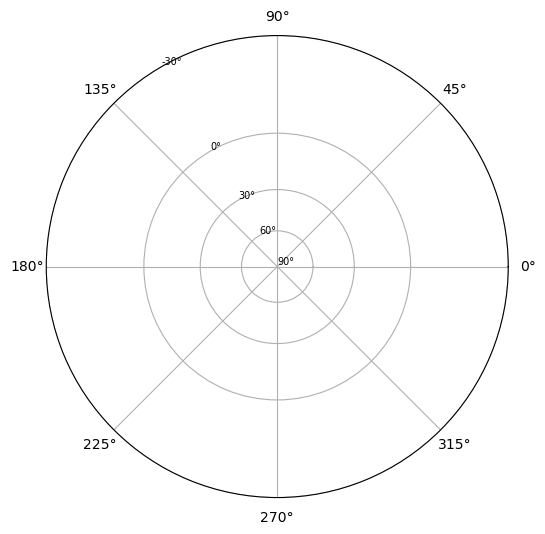

In [30]:
# plot star chart as a circular graph

# Polar plot figure
fig = plt.figure(figsize=(figsize_n,figsize_n), dpi=figsize_dpi)
ax = fig.subplots(subplot_kw={'projection': 'polar'})

# Display declination lines on the chart from -min to +max
def displayDeclinationMarksOnAxis(declination_values, dec_min, dec_max, isInverted):
    # set declination marks based on the ruler to space out lines
    ruler_declination_position = list(ruler_position_dict.values())
    ruler_declination_labels = list(ruler_position_dict.keys())
    both_label_values = [list(x) for x in zip(ruler_declination_position, ruler_declination_labels)] # for testing
    ax.set_ylim(0, max(ruler_declination_position))

    # Display Axis
    if displayDeclinationNumbers:
        ruler_declination_labels = ["{0}°".format(deg) for deg in ruler_declination_labels]
        plt.yticks(ruler_declination_position, fontsize=7)
        ax.set_yticklabels(ruler_declination_labels)
        ax.set_rlabel_position(120) # declination labels position
    else:
        plt.yticks(ruler_declination_position, fontsize=0) # do not display axis
        ax.set_yticklabels(ruler_declination_labels)
        ax.set_rlabel_position(120) # declination labels position

# Display declination lines based on hemisphere
displayDeclinationMarksOnAxis(declination_values, -30, 90, False)

# convert to x and y values for stars
x_star_labels, x_ra_values, y_dec_values, star_dict = generateStereographicProjection([])

# Set Right Ascension (astronomical 'longitude') as X (theta of polar plot)
angles_ra = np.array([0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150,
                    165, 180, 195, 210, 225, 240, 255, 270, 285, 300,
                    315, 330, 345])
plt.xticks(angles_ra * np.pi / 180, fontsize=8)
labels_ra = np.array(['$0^h$','$1^h$','$2^h$','$3^h$', '$4^h$','$5^h$',
                    '$6^h$','$7^h$', '$8^h$','$9^h$', '$10^h$',
                    '$11^h$','$12^h$','$13^h$','$14^h$','$15^h$',
                    '$16^h$','$17^h$','$18^h$','$19^h$','$20^h$', 
                    '$21^h$', '$22^h$','$23^h$'])
ax.set_xticklabels(labels_ra, fontsize=10)



In [8]:


# convert to x and y values for stars
x_star_labels, x_ra_values, y_dec_values, star_dict = generateStereographicProjection(starList=userListOfStars, 
                                                                                    northOrSouth=northOrSouth, 
                                                                                    yearSince2000=yearSince2000,
                                                                                    isPrecessionIncluded=isPrecessionIncluded,
                                                                                    maxMagnitudeFilter=maxMagnitudeFilter,
                                                                                    declination_min=declination_min,
                                                                                    declination_max=declination_max)

# Set Right Ascension (astronomical 'longitude') as X (theta of polar plot)
angles_ra = np.array([0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150,
                    165, 180, 195, 210, 225, 240, 255, 270, 285, 300,
                    315, 330, 345])
plt.xticks(angles_ra * np.pi / 180, fontsize=8)
labels_ra = np.array(['$0^h$','$1^h$','$2^h$','$3^h$', '$4^h$','$5^h$',
                    '$6^h$','$7^h$', '$8^h$','$9^h$', '$10^h$',
                    '$11^h$','$12^h$','$13^h$','$14^h$','$15^h$',
                    '$16^h$','$17^h$','$18^h$','$19^h$','$20^h$', 
                    '$21^h$', '$22^h$','$23^h$'])
ax.set_xticklabels(labels_ra, fontsize=10)

# Optiona: Label the stars with names
if displayStarNamesLabels:
    for i, txt in enumerate(x_star_labels):
        ax.annotate(txt, (x_ra_values[i], y_dec_values[i]), 
                    horizontalalignment='center', verticalalignment='bottom', 
                    fontsize=8)
for i, txt in enumerate(x_star_labels):
    logger.debug("{0}: {1:05f} RA (degrees) and {2:05f} Declination (ruler)".format(txt, np.rad2deg(x_ra_values[i]), y_dec_values[i]))
    output_string = "Proper Motion"
    logger.debug("{0} for {1} Years\n".format(output_string, yearSince2000))

ax.scatter(x_ra_values, y_dec_values, s=10, c=fig_plot_color)

# Set Default Figure Title based on variables used in calculation
years_for_title = yearSince2000
suffix = ""
if 1000 <  abs(years_for_title) and abs(years_for_title) < 1000000:
    years_for_title = years_for_title / 1000
    suffix = "K"
if abs(years_for_title) > 1000000:
    years_for_title = years_for_title / 1000000
    suffix = "M"
if yearSince2000 >= -2000: year_bce_ce = "{0} C.E".format(yearSince2000 + 2000) # postive years for C.E
if yearSince2000 < -2000: year_bce_ce = "{0} B.C.E".format(abs(yearSince2000 + 2000)) # negative years for B.C.E
figure_has_precession_extra_string = "with Precession" if isPrecessionIncluded else "without Precession"

if fig_plot_title is None: # by default sets title of plot
    ax.set_title("{0}ern Hemisphere [{1}{2} Years Since 2000 ({3})]: {4}° to {5}° {6}".format(northOrSouth,
                                                                                            years_for_title,
                                                                                            suffix,
                                                                                            year_bce_ce,
                                                                                            declination_max,
                                                                                            declination_min,
                                                                                            figure_has_precession_extra_string))
else:
    ax.set_title(fig_plot_title)

# Optional: Save plot with user-defined name/location
if save_plot_name is not None: 
    fig.savefig(save_plot_name)

# Optional: Show the plot when it has been calculated
if showPlot:
    plt.show()

NameError: name 'generateStereographicProjection' is not defined

In [18]:
def getStarList(selectStars=[]):
	# generate a star object
	# selectStars only returns a subset of all the stars saved, empty will return all in the star_data.csv file
	# stars: ["name", "RA: HH.MM.SS", Declination DD.SS, Proper Motion Speed (mas/yr), Proper Motion Angle (DD.SS), Magnitude (V, Visual)]
	star_data_list = []
	star_csv_file = 'star_data.csv'  # get file's directory, up one level, /data/star_data.csv
	star_dataframe = pd.read_csv(star_csv_file)
	for index, row in star_dataframe.iterrows():
		if len(selectStars) > 0: # get only a subset of all stars
			if row["Star Name"] in selectStars:
				star_data_list.append(row.tolist())
		else:
			star_data_list.append(row.tolist())
	return star_data_list

In [27]:
list_of_stars = getStarList()
list_of_stars = scsp.generate_star_chart.convertRAhrtoRadians(list_of_stars)

x_star_labels, x_ra_values, y_dec_values, finalPositionOfStarsDict = scsp.generate_star_chart.generateStereographicProjection([])


UnboundLocalError: cannot access local variable 'radius_of_circle_at_min_dec' where it is not associated with a value

In [25]:
list_of_stars

[['Acamar', 0.7777623479199732, -40.18, 57.1, 293.8, 3.22],
 ['Achernar', 0.426296669799615, -57.14, 95.0, 113.7, 0.54],
 ['Acrab', 4.212497593792646, -19.48, 24.6, 192.2, 2.62],
 ['Acrux', 3.25758432679525, -63.05, 38.8, 247.5, 1.28],
 ['Adhara', 1.8265597842642323, -28.58, 3.5, 67.7, 1.53],
 ['Aldebaran', 1.203913573615255, 16.3, 199.3, 161.4, 0.99],
 ['Alderamin', 5.578799509895541, 62.35, 158.4, 71.9, 2.47],
 ['Algieba', 2.705114896486878, 19.5, 341.2, 116.9, 2.23],
 ['Algol', 0.8210319689589991, 40.57, 3.4, 119.0, 2.11],
 ['Alhena', 1.7352936087953623, 16.24, 56.7, 165.9, 1.93],
 ['Alioth', 3.377284824661194, 55.57, 112.2, 94.2, 1.76],
 ['Alkaid', 3.610795334167602, 49.18, 122.1, 263.0, 1.86],
 ['Almach', 0.5405430137530771, 42.19, 65.0, 139.4, 2.17],
 ['Alnilam', 1.4669492363012337, -1.12, 1.6, 118.4, 1.72],
 ['Alnitak', 1.4868023565426696, -1.56, 3.8, 57.5, 1.9],
 ['Alphard', 2.4765494865277873, -8.39, 37.6, 336.1, 1.98],
 ['Alphecca', 4.078325407545583, 26.42, 147.8, 126.4, 2.2

### OK attempt 2

In [99]:
# hard-coding information for Northern hemisphere projection
declination_min = -30
declination_max = 90
incrementBy = 10
total_ruler_len = 1
radius_of_circle = (total_ruler_len/2) / math.tan(np.deg2rad(45 - declination_min/2))	

# querry available stars from scsp
star_dict = scsp.finalPositionOfStars(["Sirius", "Polaris", "Merak"], yearSince2000=-3300)
star_names = star_dict.keys()

# set up lists to plot
Dec_rad = []
Dec_rad2 = []
RA_rad = []

# get x and y vectors to plot
for name in star_names:
    ra_temp = star_dict[name]["RA"].split(".")
    RA_rad.append(Angle(ra_temp[0] + "h" + ra_temp[1] + "m" + ra_temp[2] + "s").rad)

    # is it in the circle 
    dec_temp = star_dict[name]["Declination"]
    dec_ruler_position = radius_of_circle * math.tan(Angle(dec_temp, unit="deg").rad)
    Dec_rad.append(Angle(dec_temp, unit="deg").deg)
    Dec_rad2.append(dec_ruler_position)
    


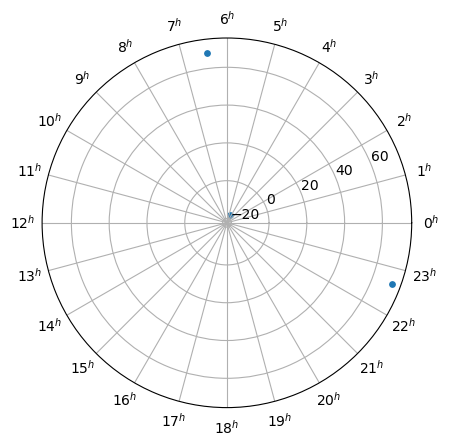

In [100]:
fig = plt.figure()
ax = fig.subplots(subplot_kw={'projection': 'polar'})

plt.scatter(RA_rad, Dec_rad, s=15)
#ax.set_rlabel_position(120) # declination labels position

# RA labels and ticks
plt.xticks(angles_ra * np.pi / 180, fontsize=8)
ax.set_xticklabels(labels_ra, fontsize=10)

plt.show()


Northern Range of Declination: -30 to 90


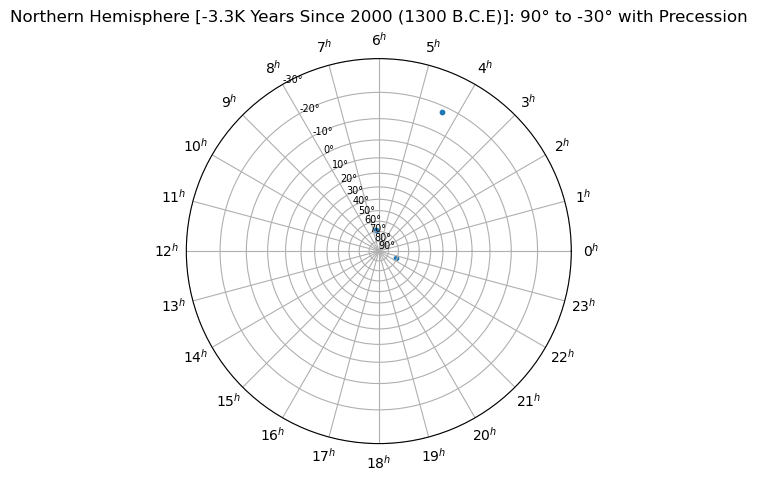

In [101]:
scsp.plotStereographicProjection(["Sirius", "Polaris", "Merak"], northOrSouth="North", yearSince2000=-3300, figsize_n=5, incrementBy=10, displayStarNamesLabels=False)

In [ ]:
finalPositionOfStarsDict = {} # {'Star Name': {"Declination" : Declination (int), "RA": RA (str)}
x_star_labels = []
x_ra_values = []
y_dec_values = []
for star in list_of_stars:
	#if maxMagnitudeFilter is None or star[5] < maxMagnitudeFilter: # Optional: Filter out stars with a magnitude greater than maxMagnitudeFilter
	#radius_of_circle = star_chart_spherical_projection.calculateRadiusOfCircle(declination_min, northOrSouth)
	total_ruler_len = 1
	radius_of_circle = (total_ruler_len/2) / math.tan(np.deg2rad(45 - declination_min/2))	
	dec_ruler_position = star_chart_spherical_projection.calculateLength(star_declination, radius_of_circle, northOrSouth) 

	in_range_value = False # Determine if within range of South/North Hemisphere
	if star_declination > declination_min and star_declination < declination_max: # only display stars within range of declination values
		in_range_value = True # North

	if in_range_value:
		finalPositionOfStarsDict[star[0]] = {"Declination" : star_declination, "RA": convertRadianstoRAhr(star_ra)} # {'Star Name': {"Declination" : Declination (int), "RA": RA (str)}
		x_star_labels.append(star[0])
		x_ra_values.append(star_ra)
		y_dec_values.append(dec_ruler_position)

In [55]:
# define ticks

angles_ra = np.array([0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150,
                    165, 180, 195, 210, 225, 240, 255, 270, 285, 300,
                    315, 330, 345])

labels_ra = np.array(['$0^h$','$1^h$','$2^h$','$3^h$', '$4^h$','$5^h$',
                    '$6^h$','$7^h$', '$8^h$','$9^h$', '$10^h$',
                    '$11^h$','$12^h$','$13^h$','$14^h$','$15^h$',
                    '$16^h$','$17^h$','$18^h$','$19^h$','$20^h$', 
                    '$21^h$', '$22^h$','$23^h$'])

In [56]:
ruler_position_dict

{-30: 0.5, 0: 0.2887, 30: 0.1667, 60: 0.0774, 90: 0.0}

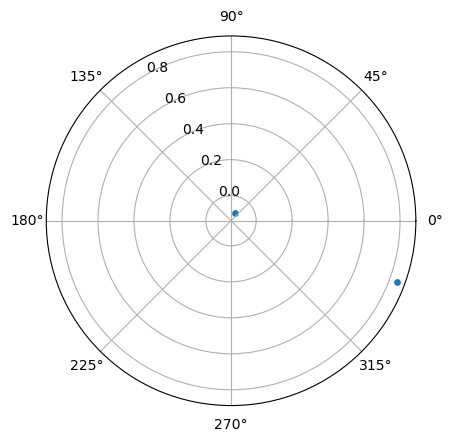

In [82]:
fig = plt.figure()
ax = fig.subplots(subplot_kw={'projection': 'polar'})


plt.scatter(RA_rad, Dec_rad2, s=15)
ax.set_rlabel_position(120) # declination labels position

plt.show()


Northern Range of Declination: -30 to 90


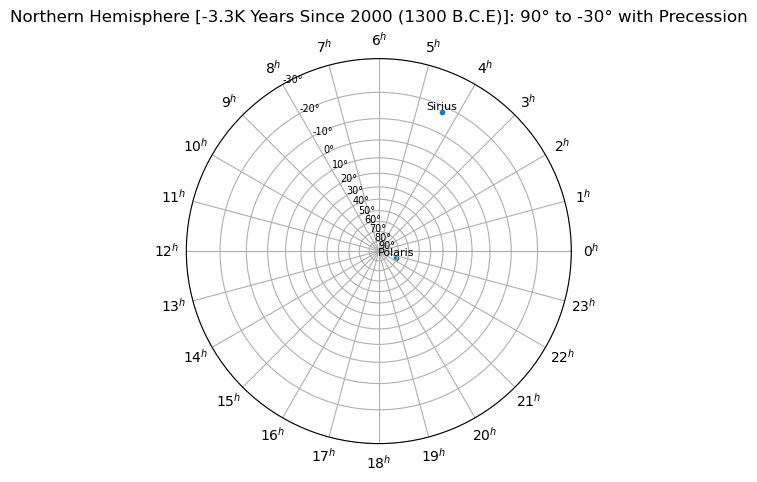

In [83]:
scsp.plotStereographicProjection(["Polaris", "Sirius"], northOrSouth="North", yearSince2000=-3300, figsize_n=5, incrementBy=10)

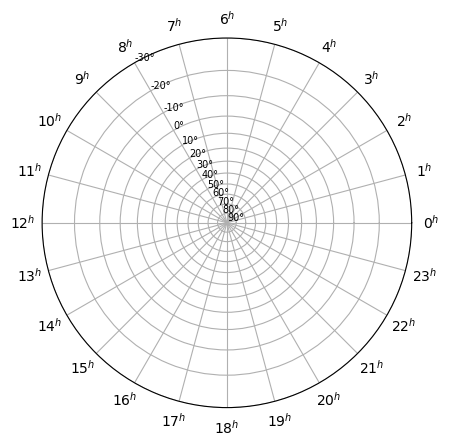

In [87]:
fig = plt.figure()
ax = fig.subplots(subplot_kw={'projection': 'polar'})

# Set declination based on hemisphere selected
declination_min = -30
declination_max = 90
incrementBy = 10

# Split up chart into North/South hemisphere
declination_values = np.arange(declination_min, declination_max+1, incrementBy) # +1 to show max value in range
ruler_position_dict = scsp.calculateRuler(declination_min, declination_max, incrementBy, northOrSouth)

# Ruler 
ruler_declination_position = list(ruler_position_dict.values())
ruler_declination_labels = list(ruler_position_dict.keys())
ax.set_ylim(0, max(ruler_declination_position))
ruler_declination_labels = ["{0}°".format(deg) for deg in ruler_declination_labels]
plt.yticks(ruler_declination_position, fontsize=7)

# Dec labels and ticks
ax.set_yticklabels(ruler_declination_labels)
ax.set_rlabel_position(120) # declination labels position

# RA labels and ticks
plt.xticks(angles_ra * np.pi / 180, fontsize=8)
ax.set_xticklabels(labels_ra, fontsize=10)

plt.scatter(RA_rad, Dec_rad2, s=15)



plt.show()


Northern Range of Declination: -30 to 90


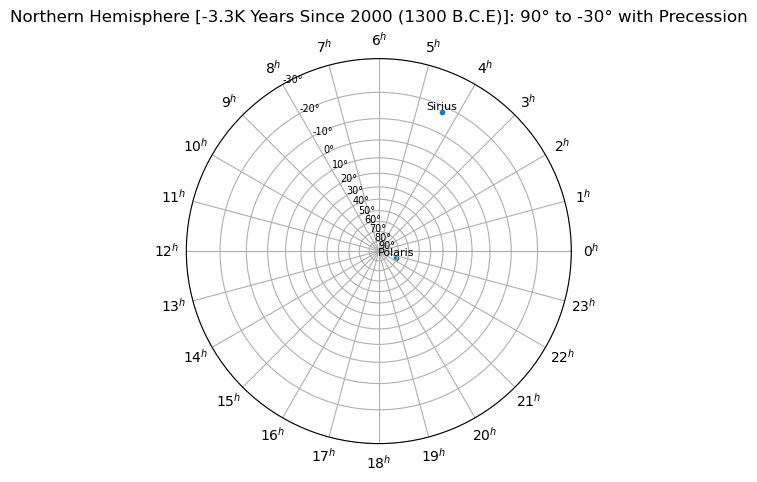

In [60]:
scsp.plotStereographicProjection(["Polaris", "Sirius"], northOrSouth="North", yearSince2000=-3300, figsize_n=5, incrementBy=10)

UnboundLocalError: cannot access local variable 'radius_of_circle_at_min_dec' where it is not associated with a value

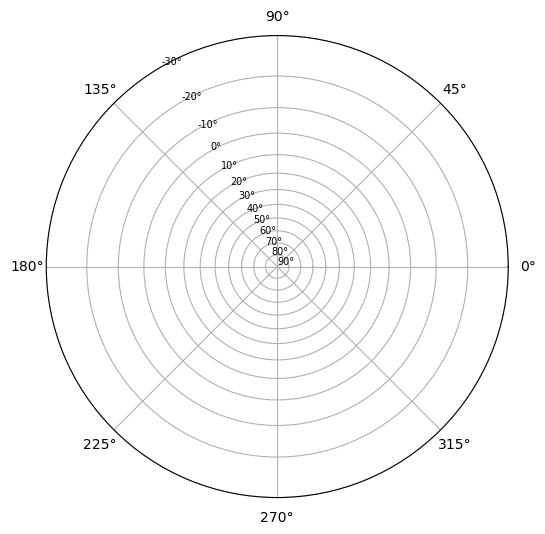

In [91]:
# plot star chart as a circular graph

# Polar plot figure
fig = plt.figure(figsize=(figsize_n,figsize_n), dpi=figsize_dpi)
ax = fig.subplots(subplot_kw={'projection': 'polar'})

# Display declination lines on the chart from -min to +max
def displayDeclinationMarksOnAxis(declination_values, dec_min, dec_max, isInverted):
    # set declination marks based on the ruler to space out lines
    ruler_declination_position = list(ruler_position_dict.values())
    ruler_declination_labels = list(ruler_position_dict.keys())
    both_label_values = [list(x) for x in zip(ruler_declination_position, ruler_declination_labels)] # for testing
    ax.set_ylim(0, max(ruler_declination_position))

    # Display Axis
    if displayDeclinationNumbers:
        ruler_declination_labels = ["{0}°".format(deg) for deg in ruler_declination_labels]
        plt.yticks(ruler_declination_position, fontsize=7)
        ax.set_yticklabels(ruler_declination_labels)
        ax.set_rlabel_position(120) # declination labels position
    else:
        plt.yticks(ruler_declination_position, fontsize=0) # do not display axis
        ax.set_yticklabels(ruler_declination_labels)
        ax.set_rlabel_position(120) # declination labels position

# Display declination lines based on hemisphere
displayDeclinationMarksOnAxis(declination_values, -30, 90, False)

# convert to x and y values for stars
x_star_labels, x_ra_values, y_dec_values, star_dict = scsp.generate_star_chart.generateStereographicProjection([])

# Set Right Ascension (astronomical 'longitude') as X (theta of polar plot)
angles_ra = np.array([0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150,
                    165, 180, 195, 210, 225, 240, 255, 270, 285, 300,
                    315, 330, 345])
plt.xticks(angles_ra * np.pi / 180, fontsize=8)
labels_ra = np.array(['$0^h$','$1^h$','$2^h$','$3^h$', '$4^h$','$5^h$',
                    '$6^h$','$7^h$', '$8^h$','$9^h$', '$10^h$',
                    '$11^h$','$12^h$','$13^h$','$14^h$','$15^h$',
                    '$16^h$','$17^h$','$18^h$','$19^h$','$20^h$', 
                    '$21^h$', '$22^h$','$23^h$'])
ax.set_xticklabels(labels_ra, fontsize=10)

